# Analysis of Trifield
### Aaron J. Heller -- 23-Jan-2022

In [1]:
import numpy as np
from numpy import pi, sqrt
from matplotlib import pyplot as plt

In [2]:
sqrt2 = sqrt(2)

def sind(deg): return np.sin(deg * pi/180)
def cosd(deg): return np.cos(deg * pi/180)

# these follow the MATLAB convention for spherical coordinates
def cart2sph(x, y, z):
    """Convert from Cartesian to spherical coordinates, using MATLAB convention
    for spherical coordinates.

    Parameters
    ----------
        x, y, z: array-like
           Cartesian coordinates

    Returns
    -------
        az, el, r: nd-array
            azimuth, elevation (radians)
            radius (input units)

    """
    r_xy = np.hypot(x, y)
    r = np.hypot(r_xy, z)
    el = np.arctan2(z, r_xy)
    az = np.arctan2(y, x)
    return az, el, r



## Analysis of Panning Gains

In [3]:
# the input matrix - left-right to mid-side 
ms_matrix = np.array(((1,  1), 
                      (1, -1)))/sqrt2

# the output matrix - center-mid-side to left-center-right
cms2lcr_matrix = np.array(((0, 1, 1), 
                           (sqrt2, 0, 0), 
                           (0, 1, -1)))/sqrt2
cms2lcr_matrix, ms_matrix

(array([[ 0.        ,  0.70710678,  0.70710678],
        [ 1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.70710678, -0.70710678]]),
 array([[ 0.70710678,  0.70710678],
        [ 0.70710678, -0.70710678]]))

In [4]:
# the mid-side to cosine-sine-width matrix
def cos_sin_w(phi, w):
    return np.array(((cosd(phi), 0), 
                     (sind(phi), 0), 
                     (0, w)))

cos_sin_w(35.26, 1) @ ms_matrix

array([[ 0.57738155,  0.57738155],
       [ 0.40820406,  0.40820406],
       [ 0.70710678, -0.70710678]])

In [5]:
# the final trifield matrix
phi = 35.26 # degrees
M_trifield = cms2lcr_matrix @ cos_sin_w(phi, 1.0) @ ms_matrix

# stereo matrix for comparison -- left to left, zero to center, right to right
M_stereo = np.array(((1, 0), (0, 0), (0, 1)))

phi, M_trifield, M_stereo

(35.26,
 array([[ 0.78864386, -0.21135614],
        [ 0.57738155,  0.57738155],
        [-0.21135614,  0.78864386]]),
 array([[1, 0],
        [0, 0],
        [0, 1]]))

In [6]:
# The pan pot angle
test_input_angle = np.linspace(-45, 45, 51, endpoint=True)  # 51 to agree with Mathematica notbook

# left-right "sine panning law"
test_input_lr = np.row_stack((cosd(test_input_angle + 45),   # left channel
                              sind(test_input_angle + 45)    # right channel
                             ))

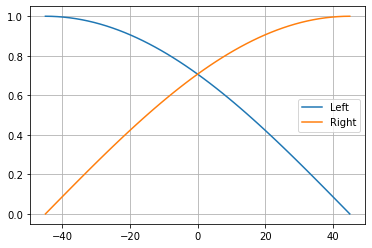

In [7]:
# plot the panning law as sanity check

plt.plot(test_input_angle, test_input_lr.T)   # transpose because plot series are in columns
plt.legend(("Left", "Right"))
plt.grid(True)
plt.show()

In [8]:
# the panning gains
G_trifield = M_trifield @ test_input_lr
G_stereo = M_stereo @ test_input_lr

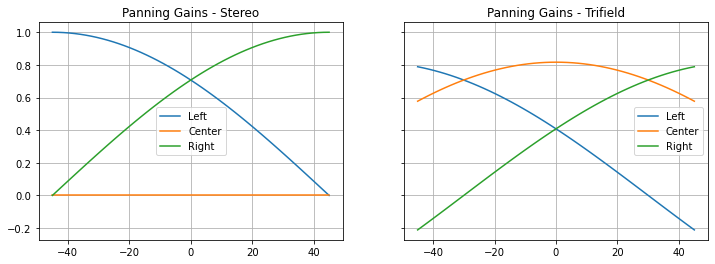

In [9]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,4))
for ax, g, l in ((axs[0], G_stereo, 'Stereo'), 
                 (axs[1], G_trifield, 'Trifield')):
    ax.plot(test_input_angle, g.T)
    ax.set_title("Panning Gains - " + l)
    ax.legend(("Left", "Center", "Right"))
    ax.grid(True)
plt.show()

## Analysis with Localization Models

In [10]:
def speaker_weights(spkr_angles):
    spkr_angles = np.asanyarray(spkr_angles)
    return np.array((np.ones_like(spkr_angles), 
                     cosd(spkr_angles), 
                     sind(spkr_angles),
                     np.zeros_like(spkr_angles)))

def rVrE(spkr_weights, G):
    # rV
    sg = spkr_weights @ np.real(G)
    rVxyz = sg[1:] / sg[0]
    rVaz, rVel, rVr = cart2sph(*rVxyz)

    # rE
    sgg = spkr_weights @ np.abs(G)**2  # in the general case G can be complex
    rExyz = sgg[1:] / sgg[0]
    rEaz, rEel, rEr = cart2sph(*rExyz)
    
    return dict(rVxyz=rVxyz, rVaz=rVaz * 180/pi, rVel=rVel, rVr=rVr,
                rExyz=rExyz, rEaz=rEaz * 180/pi, rEel=rEel, rEr=rEr)

In [11]:
spkr_weights = speaker_weights((-45, 0, +45))
# spkr_weights = speaker_weights((-90, 0, +90))

rVrE_tri = rVrE(spkr_weights, G_trifield)
rVrE_str = rVrE(spkr_weights, G_stereo)

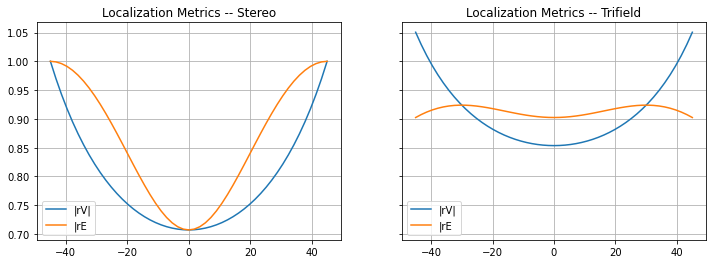

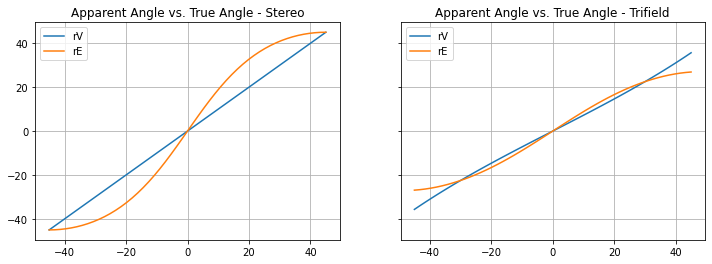

In [12]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,4))
for ax, v, l in ((axs[0], rVrE_str, 'Stereo'), 
                 (axs[1], rVrE_tri, 'Trifield')):
    ax.plot(test_input_angle, v['rVr'], label='|rV|')
    ax.plot(test_input_angle, v['rEr'], label='|rE')
    ax.set_title("Localization Metrics -- " + l)
    ax.legend()
    ax.grid(True)
plt.show()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,4))
for ax, v, l in ((axs[0], rVrE_str, 'Stereo'), 
                 (axs[1], rVrE_tri, 'Trifield')):
    ax.plot(test_input_angle, v['rVaz'], label='rV')
    ax.plot(test_input_angle, v['rEaz'], label='rE')
    ax.set_title("Apparent Angle vs. True Angle - " + l)
    ax.legend()
    ax.grid(True)
plt.show()

In [13]:
#//============================Trifield Preservation Decoders=================================
#//========================================================================================
# from Marc Lavallee's trifield.lib

M_pd32 = np.array((
    (0.8850, -0.1150),
    (0.4511, +0.4511),
    (-0.1150, +0.8850)))

M_pd43 = np.array((
    (0.9303, -0.1297, +0.0527),
    (0.3314, +0.6951, -0.1479),
    (-0.1479, +0.6951, +0.3314),
    (0.0527, -0.1297, +0.9303)))

M_pd53 = np.array((
    (0.8407, -0.1538, +0.0557),
    (0.5304, +0.3648, -0.0891),
    (-0.0279, +0.8285, -0.0279),
    (-0.0891, +0.3648, +0.5304),
    (0.0557, -0.1538, +0.8407)))

M_pd54 = np.array((
    (0.9535, -0.1084, +0.0590, -0.0324),
    (0.2533, +0.7870, -0.1989, +0.0859),
    (-0.1349, +0.5708, +0.5708, -0.1349),
    (0.0859, -0.1989, +0.7870, +0.2533),
    (-0.0324, +0.0590, -0.1084, +0.9535)))


In [14]:
# how does the preservation matrix compare to the trifield -- more to L/R less to C

M_pd32 / M_trifield

array([[1.12217954, 0.54410531],
       [0.7812858 , 0.7812858 ],
       [0.54410531, 1.12217954]])

In [15]:
# does pd53 == pd54 @ pd43?  Yes!
M_pd54 @ M_pd43 - M_pd53

array([[-1.629e-05, -4.610e-06, -7.310e-06],
       [ 1.030e-06, -5.930e-06,  4.892e-05],
       [ 3.510e-05,  1.922e-05,  3.510e-05],
       [ 4.892e-05, -5.930e-06,  1.030e-06],
       [-7.310e-06, -4.610e-06, -1.629e-05]])

In [16]:
# are they semi-unitary? Yes!

M_pd32.conj().T @ M_pd32 - np.eye(2)

array([[-5.879e-05, -5.879e-05],
       [-5.879e-05, -5.879e-05]])

In [17]:
M_pd43.conj().T @ M_pd43 - np.eye(3)

array([[-6.425e-05,  5.575e-05,  2.550e-05],
       [ 5.575e-05, -2.780e-05,  5.575e-05],
       [ 2.550e-05,  5.575e-05, -6.425e-05]])

In [18]:
M_pd54.conj().T @ M_pd54 - np.eye(4)

array([[-5.028e-05, -1.033e-05, -1.033e-05, -7.185e-05],
       [-1.033e-05, -2.559e-05, -4.716e-05, -1.033e-05],
       [-1.033e-05, -4.716e-05, -2.559e-05, -1.033e-05],
       [-7.185e-05, -1.033e-05, -1.033e-05, -5.028e-05]])

In [19]:
M_trifield.conj().T @ M_trifield - np.eye(2)

array([[-3.33066907e-16,  1.02603281e-16],
       [ 1.02603281e-16, -3.33066907e-16]])